# Tarea 7 -  Redes Secuenciales: Word Embeddings/LTSM

### ITESM - MCC
#### Tópicos selectos de AI

## Carlos E. Hdz Rincón - A01181616

# Instrucciones

## Notas
* Esta Tarea usará la base de datos de la UCI llamada Sentiment Labelled Sentences, la cual contiene comentarios de los sitios Amazon, IMDB y Yelp: https://archive.ics.uci.edu/ml/datasets/Sentiment+Labelled+Sentences  

## Acciones

1. Considerando como tokens las palabras del conjunto de datos, construir tu vocabulario/diccionario para indexar las palabras (asociar un número entero a cada palabra).

2. Indica el total de palabras diferentes de los documentos y reduce el número de palabras de tu vocabulario a la cantidad que consideres adecuada. El tamaño que elijas para tu vocabulario lo usarás para los siguientes incisos, lo llamaremos n_vocabulario.

3. A partir de la longitud de los documentos de la base de datos, elige una longitud para el tamaño de la secuencia de entrada de cada documento. Es decir, elige la cantidad de palabras a considerar en cada documento (es decir cada archivo txt de la base de datos). Llamaremos n_secuencias a este valor. NOTA: Puedes obtener el promedio y desviación estándar de palabras de cada documento de la base de datos para apoyarte a seleccionar dicho valor.

4. Normaliza cada documento (pad_sequences) de la base de datos con los valores elegidos anteriormente.

5. Construye una red neuronal para generar los WordEmbeddings de cada palabra. El tamaño de los vectores continuos debe ser 40. Llamemos n_embedded a dicho valor.

6. Utiliza los vectores continuos/densos (word embeddings) construidos anteriormente para construir un modelo de red neuronal secuencial LSTM que ayude a clasificar el sentimiento de los documentos del conjunto de datos original en positivo o negativo. Utiliza una partición de 80% (train) y 20% (test). Es decir, este es un problema biclase.

7. Utiliza los vectores continuos/densos (word embeddings) construidos anteriormente para construir un modelo de red neuronal secuencial LSTM que ayude a clasificar los documentos de acuerdo al tipo de sitio web al que pertenece. Utiliza una partición de 80% (train) y 20% (test).    

# Conclusiones

## Dataset
Se hizo un split de 80-10-10 para train-val-test

## Word Embeddings

Se utilizaron los siguentes valores:
* n_vocabulario = 10000
* n_secuencias = 13
* n_embedded = 40

Para las secuencias, se determinó ese valor dados el promedio de palabras y su desviación estándar:

|Site|Average comment size|Std Dev.|
|---|---|---|
|Amazon|10.246|6.687616033251925|
|IMDB|14.355|9.610793013187951|
|Yelp|10.894|6.260028111115153|
|General dataset|11.831666666666667|7.872440684417092|

El número máximo de tokens únicos es 5274.

Los Word Embeddings se generaron por separado y una vez generados, fueron congelados para ser reutilizados por nuevos modelos para el análisis de sentimientos.

## Sentiment analyzer

Se obtuvo resultados muy buenos rondando 98-99% de accuracy y el modelo convergió correctamente demostrado por las gráficas con un batch de 32 y 25 epochs usando un optimizador Adam con LR de 0.01 en un entrenamiento de 25 segundos.

## Website classifier
Con batch 64, 150 epochs y un optimizador Adam con LR 0.03 el modelo generalizó correctamente a los datos de validación y de prueba, pero se consiguió un accuracy de alrededor de 60% que no mejora con más epochs.

Esto puede sugerir que se necesitan conseguir más ejemplos para correctamente identificar las fuentes de cada comentario. Eliminar stop words o tokenizar en n-gramas también pueden ayudar para mantener un poco de contexto.

Este supuesto pareciera estar soportado por el reporte de clasificación que claramente indica que los comentarios de IMDB tuvieron un mejor accuracy que aquellos de Amazon y Yelp, y esto puede estar relacionado con el hecho que los comentarios de IMDB son más largos que los de Amazon y Yelp.

### Website classifier with 100 embeddings

Otra posible explicación es que los 40 embeddings no son suficientes para poder aprender comentarios para clasificar la fuente de los comentarios.

En un experimento extra, se aumentó el número de n_embeddings de 40 a 100 y aplicando Dropout, se consigue un accuracy de alrededor de **80%** en tan solo 10 epochs.


# 1. Imports

In [0]:
%matplotlib inline
#import tensorflow as tf

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, LSTM
from keras.layers.embeddings import Embedding
from keras.utils import to_categorical
import keras

import matplotlib
import matplotlib.pyplot as plt

import numpy as np
from numpy import array

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split

#from imutils import paths
#import shutil

# Needed to load the Dataset from Google Drive
#from google.colab import drive

import os
import time
import random
import statistics 

Using TensorFlow backend.


# 2. Carga de Datos


In [0]:
#!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00331/sentiment%20labelled%20sentences.zip -P /content/drive/My\ Drive/Datasets/AmazonIMDBYelpComments
#!unzip /content/drive/My\ Drive/Datasets/AmazonIMDBYelpComments/sentiment_labelled_sentences.zip -d /content/drive/My\ Drive/Datasets/AmazonIMDBYelpComments/

# 3. Utilidades para evaluación del modelo

In [0]:
DATASET_BASE_FOLDER = "/content/drive/My Drive/Datasets/AmazonIMDBYelpComments/"


def load_comment_data(filename: str) -> tuple:
    comments = []
    labels = []
    
    with open(os.path.join(DATASET_BASE_FOLDER, filename)) as f:
        lines = [line.rstrip() for line in f.readlines()]
    
    for line in lines:
        comment, label = line.split("\t")
        label = int(label)
        
        comments.append(comment)
        labels.append(label)
    
    return comments, labels

In [0]:
def train_model(model_to_fit: keras.engine.training.Model,
                train_tuple: tuple,
                val_tuple: tuple,
                epochs: int,
                batch: int,
                callbacks: list = None):
    
    #step_size_train = train_generator.n//train_generator.batch_size
    #step_size_valid = valid_generator.n//valid_generator.batch_size

    t = time.process_time()
    
    trained_model_history = model_to_fit.fit(x=train_tuple[0],
                                             y=train_tuple[1],
                                             validation_data=val_tuple,
                                             epochs=epochs,
                                             batch_size=batch)
    
    elapsed_time = time.process_time() - t
    
    print(f"\n\n ********* Training time: {elapsed_time} s.")
    return trained_model_history

def graph_loss_accuracy(h_model,
                        epochs: int,
                        subtitle: str = ""):
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0,epochs),h_model.history["accuracy"],label="train_acc")
    plt.plot(np.arange(0,epochs),h_model.history["val_accuracy"],label="val_acc")
    plt.title("Training and Validation Accuracy" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure()
    plt.plot(np.arange(0,epochs),h_model.history["loss"],label="train_loss") 
    plt.plot(np.arange(0,epochs),h_model.history["val_loss"],label="val_loss")
    plt.title("Training and Validation Loss" 
              + f" ({subtitle})" if subtitle else "")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()

    plt.show()

# Helper functions for reporting

def print_dataset_prediction_report(predictions,
                                    real_labels,
                                    human_readable_labels: list,
                                    dataset_title: str):
    print(f"\n\n ****** {dataset_title} Dataset Prediction Report ******")
    
    # For classification_report the one_hot_encoding test labels are needed,
    #  these are passed in the validation_tuple[1] and test_tuple[1]
    print(f"\n\nClassification Report - {dataset_title}:")
    print(classification_report(real_labels, 
                            predictions,
                            target_names=human_readable_labels))
    
    print(f"\n\nConfusion Matrix: - {dataset_title}:")
    print(confusion_matrix(real_labels,
                           predictions))
    
    print("\n")

def print_optimizer_summary(model: keras.engine.training.Model):
    optimizer_config = model.optimizer.get_config()
    
    for key in optimizer_config.keys():
        print(f"\t{key}: {optimizer_config[key]}")


def prepare_labels_for_reporting(predictions, 
                                 real_labels, 
                                 is_binary_problem:bool) -> tuple:
    if is_binary_problem:
        report_pred = predictions.round()
        real_labels = real_labels
    else:
        report_pred = predictions.argmax(axis=1)
        real_labels = real_labels.argmax(axis=1)
    
    return report_pred, real_labels


def evaluate_model(model_to_fit: keras.engine.training.Model,
                   train_tuple: tuple,
                   val_tuple: tuple,
                   test_tuple: tuple,               
                   epochs: int,
                   batch: int,
                   labels: list,
                   callbacks: list = None,
                   title: str = "",
                   is_binary_problem: bool = True):
    
    title = "" if not title else f"{title} - "
    graph_subtitle = f"{title}Epochs: {epochs} Batch: {batch}"

    trained_model_history = train_model(model_to_fit,
                                        train_tuple,
                                        val_tuple,
                                        epochs,
                                        batch,
                                        callbacks=callbacks)
    
    graph_loss_accuracy(trained_model_history,
                        epochs=len(trained_model_history.epoch), # In case we early stopped,
                        subtitle=graph_subtitle)
    

    print("\n\n ************* Model Information *************\n")
    
    model_to_fit.summary()
    
    print(f"Training Dataset Size: {len(train_tuple[0])}")
    print(f"Validation Dataset Size: {len(val_tuple[0])}")
    print(f"Batch size: {batch}")
    print(f"Epochs: {epochs}")
    print_optimizer_summary(model_to_fit)
    


    # ------------- Validation ------------------
    val_model_predictions = model_to_fit.predict(val_tuple[0],
                                                 batch_size=batch)
    
    report_pred, real_labels = prepare_labels_for_reporting(val_model_predictions,
                                                            val_tuple[1],
                                                            is_binary_problem)
    
    print_dataset_prediction_report(report_pred,
                                    real_labels,
                                    labels,
                                    "Validation")
    

    # ------------- Test ------------------

    test_model_predictions = model_to_fit.predict(test_tuple[0],
                                                  batch_size=batch)
    
    report_pred, real_labels = prepare_labels_for_reporting(test_model_predictions,
                                                            test_tuple[1],
                                                            is_binary_problem)
    
    print_dataset_prediction_report(report_pred,
                                    real_labels,
                                    labels,
                                    "Test")

# 4. Generación de embeddings

## 4.1 Carga de documentos

In [0]:
amazon_X, amazon_Y = load_comment_data("amazon_labelled.txt")
imdb_X, imdb_Y = load_comment_data("imdb_labelled.txt")
yelp_X, yelp_Y = load_comment_data("yelp_labelled.txt")

# Let's combine them all
docs_X = amazon_X + imdb_X + yelp_X
docs_X = np.asarray(docs_X)

# Sentiment labels 0 = Negative, 1 = Positive
docs_Y = amazon_Y + imdb_Y + yelp_Y
docs_Y = np.asarray(docs_Y)

# Source labels, 0 = Amazon, 1 = IMDB, Yelp = 2
amazon_labels = np.full(len(amazon_X), 0)
imdb_labels = np.full(len(imdb_X), 1)
yelp_labels = np.full(len(yelp_X), 2)
source_Y = np.concatenate((amazon_labels, imdb_labels, yelp_labels))

# One-hot encode the labels:
source_Y = to_categorical(source_Y)

print(f"Examples in Amazon: {len(amazon_X)}")
print(f"Examples in IMDB: {len(imdb_X)}")
print(f"Examples in Yelp: {len(yelp_X)}")

print(f"Merged database: {len(docs_X)}")
print(f"Source labels size: {len(source_Y)}")

SENTIMENT_LABELS = ["Negative", "Positive"]
SOURCE_LABELS = ["Amazon", "IMDB", "Yelp"]


Examples in Amazon: 1000
Examples in IMDB: 1000
Examples in Yelp: 1000
Merged database: 3000
Source labels size: 3000


In [0]:
amazon_word_count = [len(line.split()) for line in amazon_X]
imdb_word_count = [len(line.split()) for line in imdb_X]
yelp_word_count = [len(line.split()) for line in yelp_X]

all_docs_count = amazon_word_count + imdb_word_count + yelp_word_count

print("Average comment size\tStd Dev.\n")
print(f"Amazon: {sum(amazon_word_count)/len(amazon_X)}\t{statistics.stdev(amazon_word_count)}")
print(f"IMDB: {sum(imdb_word_count)/len(imdb_X)}\t{statistics.stdev(imdb_word_count)}")
print(f"Yelp: {sum(yelp_word_count)/len(yelp_X)}\t{statistics.stdev(yelp_word_count)}")

print(f"\nGeneral dataset: {sum(all_docs_count)/len(all_docs_count)}\t{statistics.stdev(all_docs_count)}")

Average comment size	Std Dev.

Amazon: 10.246	6.687616033251925
IMDB: 14.355	9.610793013187951
Yelp: 10.894	6.260028111115153

General dataset: 11.831666666666667	7.872440684417092


## 4.2 Parámetros para word embeddings

In [0]:
n_vocabulario = 10000
n_secuencias = 13
n_embedded = 40

## 4.3 Tokenizacion y normalización de tokens

In [0]:
tokens = Tokenizer(num_words=n_vocabulario,
                   filters='!"#$%&()*+,-./:;<=>?...',
                   lower=True,
                   split=' ',
                   oov_token='#')
tokens.fit_on_texts(docs_X)
print(tokens.word_index)

{'#': 1, 'the': 2, 'and': 3, 'i': 4, 'a': 5, 'is': 6, 'it': 7, 'to': 8, 'this': 9, 'of': 10, 'was': 11, 'in': 12, 'for': 13, 'not': 14, 'that': 15, 'with': 16, 'my': 17, 'very': 18, 'good': 19, 'on': 20, 'great': 21, 'you': 22, 'but': 23, 'have': 24, 'movie': 25, 'are': 26, 'as': 27, 'so': 28, 'phone': 29, 'film': 30, 'be': 31, 'all': 32, 'one': 33, 'had': 34, 'at': 35, 'food': 36, 'like': 37, 'just': 38, 'place': 39, "it's": 40, 'time': 41, 'service': 42, 'an': 43, 'were': 44, 'if': 45, 'from': 46, 'bad': 47, 'really': 48, 'there': 49, 'they': 50, 'we': 51, 'well': 52, 'out': 53, 'has': 54, 'would': 55, 'about': 56, 'no': 57, 'or': 58, 'your': 59, 'only': 60, 'by': 61, 'best': 62, "don't": 63, 'even': 64, 'here': 65, 'ever': 66, 'up': 67, 'also': 68, 'will': 69, 'back': 70, 'me': 71, 'when': 72, 'more': 73, 'than': 74, 'quality': 75, 'go': 76, 'what': 77, 'love': 78, 'he': 79, "i've": 80, 'can': 81, 'made': 82, 'which': 83, 'because': 84, 'how': 85, 'product': 86, 'too': 87, 'work': 8

In [0]:
encoded_docs = tokens.texts_to_sequences(docs_X)
print(encoded_docs)

[[28, 49, 6, 57, 117, 13, 71, 8, 371, 7, 12, 65, 12, 2, 187, 579, 4, 76, 61, 5, 2268], [19, 158, 92, 527], [21, 13, 2, 1094], [2269, 8, 242, 13, 1095, 1096, 73, 74, 1487, 152, 1488, 303], [2, 879, 6, 21], [4, 24, 8, 2270, 2, 371, 8, 89, 7, 8, 278, 67, 144, 8, 89, 477, 372], [45, 22, 24, 373, 1489, 58, 373, 2271, 1097, 145, 1098, 2, 436, 10, 880, 325, 10, 118, 33, 61, 33], [45, 22, 26, 747, 881, 22, 260, 24, 9], [1099, 8, 135, 4, 437, 17, 160], [77, 5, 153, 10, 160, 3, 41], [3, 2, 103, 75, 6, 21], [79, 11, 18, 243, 72, 146, 46, 2, 438, 116, 8, 2, 1490, 116], [45, 2, 137, 44, 2272, 61, 5, 2273, 244, 2274, 4, 374, 8, 1491, 2275, 1100, 3, 2276, 103, 46, 2, 113], [18, 19, 75, 261], [2, 375, 6, 18, 1101, 27, 2, 138, 882, 6, 14, 18, 231, 35, 32], [201, 104, 13, 93, 33, 106, 54, 5, 653, 1492, 29], [4, 883, 326, 94, 14, 31, 2277], [28, 176, 28, 19], [95, 21], [7, 2278, 168, 39, 12, 5, 117, 15, 245, 22, 1102, 85, 182, 15, 2279, 55, 262], [4, 216, 20, 2280, 884, 3, 2281, 32, 2282, 23, 96, 14, 89,

In [0]:
padded_docs = pad_sequences(encoded_docs,
                            maxlen=n_secuencias,
                            padding='post')
print(padded_docs)

[[ 371    7   12 ...   61    5 2268]
 [  19  158   92 ...    0    0    0]
 [  21   13    2 ...    0    0    0]
 ...
 [ 272    4   11 ...    0    0    0]
 [  11 2148    3 ...  369  300   41]
 [   2 5273   61 ...  628    2  489]]


## 4.4 Generación de Word embeddings para todos los documentos

In [0]:
word_embeddings = Sequential([
                        Embedding(input_dim=n_vocabulario,
                                  output_dim=n_embedded,
                                  input_length=n_secuencias),
                        
                        Flatten(),

                        Dense(1, activation='sigmoid'),

                    ], name = "WordEmbeddings")

# Add an optimizer

word_embeddings.compile(optimizer='adam',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])

word_embeddings.fit(padded_docs,
                    docs_Y,
                    epochs=40,
                    verbose=0)

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [0]:
# Revisamos accuracy de modelo
loss, accuracy = word_embeddings.evaluate(padded_docs, docs_Y, verbose=1)
print('Accuracy: %f' % (accuracy*100))

3000/3000 [==============================] - 0s 25us/step
Accuracy: 100.000000


## 4.5 Quitarle la salida al modelo de Word Embeddings para reutilizarlo en nuevos modelos de clasificacion

In [0]:
word_embeddings.summary()

Model: "WordEmbeddings"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 13, 40)            400000    
_________________________________________________________________
flatten_1 (Flatten)          (None, 520)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 521       
Total params: 400,521
Trainable params: 400,521
Non-trainable params: 0
_________________________________________________________________


In [0]:
topless_embeddings = Model(inputs=word_embeddings.input,
                           outputs=word_embeddings.get_layer('embedding_1').output)
topless_embeddings.trainable = False

topless_embeddings.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1_input (InputLaye (None, 13)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 13, 40)            400000    
Total params: 400,000
Trainable params: 0
Non-trainable params: 400,000
_________________________________________________________________


# 5. Clasificación de sentimiento usando LSTM

## 5.1 Preparación de Dataset

Dividiremos en 80-10-10 para entrenamiento, validacion y prueba.

In [0]:
# Divide in 80-10-10
x_train, x_valid, y_train, y_valid = train_test_split(padded_docs,
                                                      docs_Y,
                                                      test_size=0.2,
                                                      shuffle= True)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid,
                                                    y_valid,
                                                    test_size=0.5,
                                                    shuffle= False)

print(f"Train size: {len(x_train)}")
print(f"Valid size: {len(x_valid)}")
print(f"Test size: {len(y_valid)}")

Train size: 2400
Valid size: 300
Test size: 300


## 5.2 Sentiment Prediction

Train on 2400 samples, validate on 300 samples
Epoch 1/25
2400/2400 [==============================] - 1s 394us/step - loss: 0.2671 - accuracy: 0.9300 - val_loss: 0.1368 - val_accuracy: 0.9600
Epoch 2/25
2400/2400 [==============================] - 1s 266us/step - loss: 0.1150 - accuracy: 0.9583 - val_loss: 0.1124 - val_accuracy: 0.9633
Epoch 3/25
2400/2400 [==============================] - 1s 255us/step - loss: 0.0991 - accuracy: 0.9621 - val_loss: 0.0985 - val_accuracy: 0.9700
Epoch 4/25
2400/2400 [==============================] - 1s 256us/step - loss: 0.0851 - accuracy: 0.9671 - val_loss: 0.0901 - val_accuracy: 0.9767
Epoch 5/25
2400/2400 [==============================] - 1s 263us/step - loss: 0.0727 - accuracy: 0.9729 - val_loss: 0.0779 - val_accuracy: 0.9833
Epoch 6/25
2400/2400 [==============================] - 1s 254us/step - loss: 0.0580 - accuracy: 0.9833 - val_loss: 0.0755 - val_accuracy: 0.9800
Epoch 7/25
2400/2400 [==============================] - 1s 259us/step - loss:

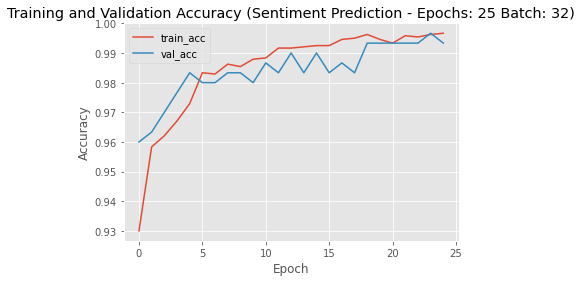

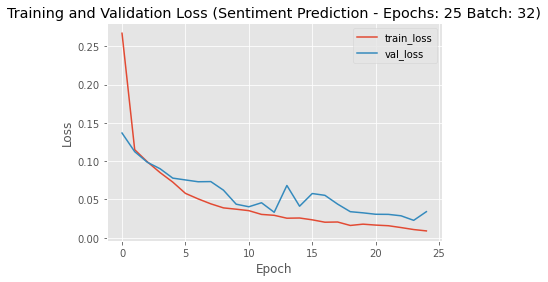



 ************* Model Information *************

Model: "Sentiment"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 13, 40)            400000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 41        
Total params: 413,001
Trainable params: 13,001
Non-trainable params: 400,000
_________________________________________________________________
Training Dataset Size: 2400
Validation Dataset Size: 300
Batch size: 32
Epochs: 25
	learning_rate: 0.0010000000474974513
	rho: 0.8999999761581421
	decay: 0.0
	epsilon: 1e-07


 ****** Validation Dataset Prediction Report ******


Classification Report - Validation:
              precision    recall  f1-score   support

    N

In [0]:
sentiment_batch = 32

sentiment_model = Sequential([
                        topless_embeddings,
                        
                        LSTM(n_embedded),

                        Dense(1, activation='sigmoid'),

                    ], name = "Sentiment")

# Add an optimizer

sentiment_model.compile(optimizer='rmsprop',
                        loss='binary_crossentropy',
                        metrics=['accuracy'])


evaluate_model(sentiment_model,
                (x_train, y_train),
                (x_valid, y_valid),
                (x_test, y_test),                 
                epochs=25,
                batch=sentiment_batch,
                labels=SENTIMENT_LABELS,
                callbacks = None,
                title = "Sentiment Prediction")

# 6. Detección de sitio web usando LSTM

## 6.1 Preparacion de dataset


In [0]:
# Divide in 80-10-10
x_train, x_valid, y_train, y_valid = train_test_split(padded_docs,
                                                      source_Y,
                                                      test_size=0.2,
                                                      shuffle= True)

x_valid, x_test, y_valid, y_test = train_test_split(x_valid,
                                                    y_valid,
                                                    test_size=0.5,
                                                    shuffle= False)

print(f"Train size: {len(x_train)}")
print(f"Valid size: {len(x_valid)}")
print(f"Test size: {len(y_valid)}")

Train size: 2400
Valid size: 300
Test size: 300


## 6.2 Prediccion de fuente

Train on 2400 samples, validate on 300 samples
Epoch 1/150
2400/2400 [==============================] - 1s 335us/step - loss: 1.0949 - accuracy: 0.3638 - val_loss: 1.0754 - val_accuracy: 0.4267
Epoch 2/150
2400/2400 [==============================] - 0s 177us/step - loss: 1.0774 - accuracy: 0.4054 - val_loss: 1.0741 - val_accuracy: 0.4267
Epoch 3/150
2400/2400 [==============================] - 0s 173us/step - loss: 1.0724 - accuracy: 0.4125 - val_loss: 1.0707 - val_accuracy: 0.4000
Epoch 4/150
2400/2400 [==============================] - 0s 181us/step - loss: 1.0684 - accuracy: 0.4187 - val_loss: 1.0668 - val_accuracy: 0.4433
Epoch 5/150
2400/2400 [==============================] - 0s 177us/step - loss: 1.0534 - accuracy: 0.4533 - val_loss: 1.0535 - val_accuracy: 0.4333
Epoch 6/150
2400/2400 [==============================] - 0s 176us/step - loss: 1.0580 - accuracy: 0.4442 - val_loss: 1.0539 - val_accuracy: 0.4467
Epoch 7/150
2400/2400 [==============================] - 0s 173us/step 

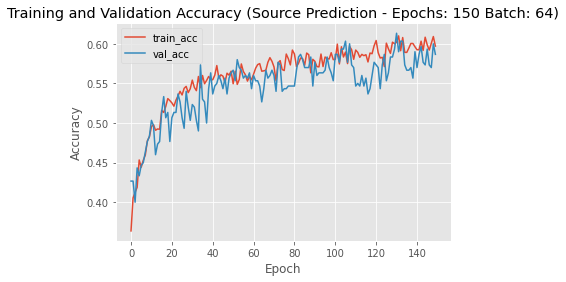

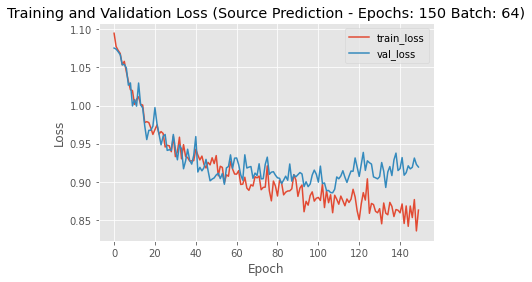



 ************* Model Information *************

Model: "Source_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 13, 40)            400000    
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 13, 40)            0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 40)                12960     
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 123       
Total params: 413,083
Trainable params: 13,083
Non-trainable params: 400,000
_________________________________________________________________
Training Dataset Size: 2400
Validation Dataset Size: 300
Batch size: 64
Epochs: 150
	learning_rate: 0.029999999329447746
	beta_1: 0.8999999761581421
	beta_2: 0.9990000128746033
	decay: 0.0
	e

In [0]:
source_batch = 64

source_model = Sequential([
                            topless_embeddings,
                           
                            keras.layers.SpatialDropout1D(0.2),
                            
                            LSTM(n_embedded, dropout=0.5, recurrent_dropout=0.2),

                            Dense(3, activation='softmax'),

                           ], name = "Source_Model")

# Add an optimizer

source_model.compile(optimizer=keras.optimizers.Adam(
                                    learning_rate=0.03
                                ),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

evaluate_model(source_model,
                (x_train, y_train),
                (x_valid, y_valid),
                (x_test, y_test),                 
                epochs=150,
                batch=source_batch,
                labels=SOURCE_LABELS,
                callbacks = None,
                title = "Source Prediction",
               is_binary_problem = False)


## 6.3 Predicción de fuente con 100 embeddings

Aumentaremos y entrenaremos el número de embeddings 

/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 2400 samples, validate on 300 samples
Epoch 1/10
2400/2400 [==============================] - 2s 807us/step - loss: 1.0850 - accuracy: 0.3829 - val_loss: 1.0132 - val_accuracy: 0.5300
Epoch 2/10
2400/2400 [==============================] - 1s 607us/step - loss: 0.9316 - accuracy: 0.5583 - val_loss: 0.8057 - val_accuracy: 0.6867
Epoch 3/10
2400/2400 [==============================] - 1s 620us/step - loss: 0.7628 - accuracy: 0.6704 - val_loss: 0.5829 - val_accuracy: 0.7800
Epoch 4/10
2400/2400 [==============================] - 1s 614us/step - loss: 0.6189 - accuracy: 0.7517 - val_loss: 0.5138 - val_accuracy: 0.7967
Epoch 5/10
2400/2400 [==============================] - 1s 623us/step - loss: 0.5360 - accuracy: 0.7887 - val_loss: 0.4745 - val_accuracy: 0.8200
Epoch 6/10
2400/2400 [==============================] - 1s 605us/step - loss: 0.4633 - accuracy: 0.8300 - val_loss: 0.4584 - val_accuracy: 0.8100
Epoch 7/10
2400/2400 [==============================] - 1s 615us/step - loss:

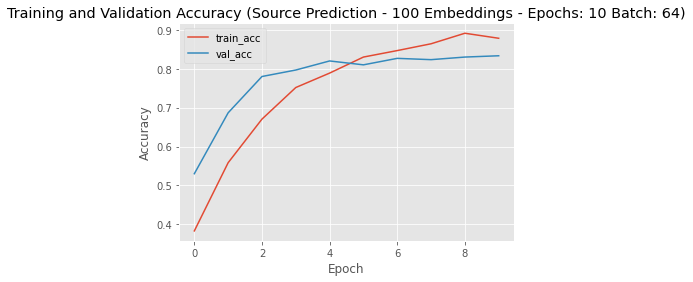

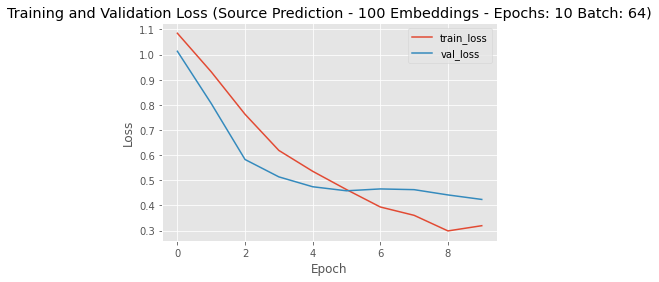



 ************* Model Information *************

Model: "Source_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 13, 100)           1000000   
_________________________________________________________________
spatial_dropout1d_8 (Spatial (None, 13, 100)           0         
_________________________________________________________________
lstm_9 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dense_10 (Dense)             (None, 3)                 303       
Total params: 1,080,703
Trainable params: 1,080,703
Non-trainable params: 0
_________________________________________________________________
Training Dataset Size: 2400
Validation Dataset Size: 300
Batch size: 64
Epochs: 10
	learning_rate: 0.003000000026077032
	beta_1: 0.8999999761581421
	beta_2: 0.9990000128746033
	decay: 0.0
	eps

In [25]:
source_batch = 64

source_model_100_embeddings = Sequential([
                            Embedding(input_dim=n_vocabulario,
                                  output_dim=100,
                                  input_length=n_secuencias),
                           
                            keras.layers.SpatialDropout1D(0.5),
                            
                            LSTM(100, dropout=0.8, recurrent_dropout=0.2),

                            Dense(3, activation='softmax'),

                           ], name = "Source_Model")

# Add an optimizer

source_model_100_embeddings.compile(optimizer=keras.optimizers.Adam(
                                    learning_rate=0.003
                                ),
                        loss='categorical_crossentropy',
                        metrics=['accuracy'])

evaluate_model(source_model_100_embeddings,
                (x_train, y_train),
                (x_valid, y_valid),
                (x_test, y_test),                 
                epochs=10,
                batch=source_batch,
                labels=SOURCE_LABELS,
                callbacks = None,
                title = "Source Prediction - 100 Embeddings",
               is_binary_problem = False)